In [ ]:
import numpy as np
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix
import cv2
from matplotlib import pyplot as plt

In [118]:
def mask_location(mask):
    '''
    Get all location that in the mask region
    '''
    x, y = np.nonzero(mask)
    return list(zip(x, y))

def normalize_mask(mask_img):
    '''
    Normalize the mask

    Para:
    mask: a mask image, the unwanted part is 255, the background part is 0
    
    Return:
    return a mask_img with the same size but only one channel. 
    The unwanted part is normalized to 1 and background part is 0
    '''
  
    mask = np.atleast_3d(mask_img).astype(np.float64) / 255.
    mask[mask != 1] = 0
    mask = mask[:,:,0]

    return mask

def get_templete_coordinate(mask, coef = 1.2):
    '''
    Function to get the template coordinate according to the mask 
    
    Para
    mask: A normalized mask image

    coef: To determain the size of templete         

    Return
    The four coordinaates 
    '''
    mask_height, mask_width = mask.shape

    x, y = np.nonzero(mask)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)

    x_mid = (x_max + x_min) / 2
    y_mid = (y_max + y_min) / 2

    # Get d = max - min
    # coef * d to determain the size of templete 
    w = x_max - x_min
    h = y_max - y_min
    w = coef * w
    h = coef * h

    x_min = np.max([x_mid - w/2, 0])
    x_max = np.min([x_mid + w/2, mask_width])
    y_min = np.max([y_mid - h/2, 0])
    y_max = np.min([y_mid + h/2, mask_height])

    return int(x_min), int(x_max), int(y_min), int(y_max)

    

204 266 66 131
(array([198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 200, 200, 200,
       200, 200, 200, 201, 201, 201, 201, 201, 201, 202, 202, 202, 202,
       202, 203, 203, 203, 203, 203, 204, 204, 204, 204, 204, 205, 205,
       205, 205, 205, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207,
       208, 208, 208, 208, 208, 209, 209, 209, 209, 209], dtype=int64), array([64, 65, 66, 67, 68, 64, 65, 66, 67, 68, 64, 65, 66, 67, 68, 69, 64,
       65, 66, 67, 68, 69, 64, 65, 66, 67, 68, 64, 65, 66, 67, 68, 64, 65,
       66, 67, 68, 64, 65, 66, 67, 68, 64, 65, 66, 67, 68, 64, 65, 66, 67,
       68, 64, 65, 66, 67, 68, 64, 65, 66, 67, 68], dtype=int64))


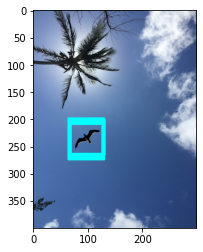

In [117]:
# Read the main image
img_rgb = cv2.imread("output/1/result.png")
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)   # convenient to use plt.imshow to see the image


# Convert it to grayscale
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# Read the template
mask = cv2.imread("input/1/mask.png")
mask = normalize_mask(mask)
x_min, x_max, y_min, y_max = get_templete_coordinate(mask)

print(x_min, x_max, y_min, y_max)

template = img_gray[x_min:x_max, y_min:y_max]
mask_tem = (mask == 0).astype(np.float32)

mask_tem = mask_tem[x_min:x_max, y_min:y_max]

w, h = template.shape

# use templete to find matching region in the img_gray
res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED, mask = mask_tem)


# Specify a threshold
threshold = 0.99
 
# Store the coordinates of matched area in a numpy array
loc = np.where(res >= threshold)
print(loc)

# Draw a rectangle around the matched region.
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 255, 255), 2)
 
# Show the final image with the matched area.
plt.imshow(img_rgb)

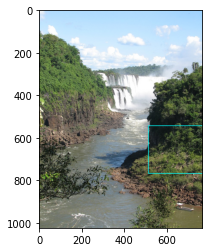

In [156]:
# read mask image
# Note the unwanted region is labelled as 255 in mask.jpg
mask = cv2.imread("mask.jpg")
mask = normalize_mask(mask)
x_min, x_max, y_min, y_max = get_templete_coordinate(mask, coef=1.5)

# read the matching image
matching_img = cv2.imread("matching.jpg")
matching_img = cv2.cvtColor(matching_img, cv2.COLOR_BGR2RGB)
matching_img_gray = cv2.cvtColor(matching_img, cv2.COLOR_BGR2GRAY)

# read the orginal image with mask 
original_img = cv2.imread("original_with_mask.jpg")
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

# Get the template 
template = original_img_gray[x_min:x_max, y_min:y_max]

# Get the mask for template
template_mask = (mask == 0).astype(np.uint8)
template_mask = template_mask[x_min:x_max, y_min:y_max]

# Do the template matching
res = cv2.matchTemplate(matching_img_gray, template, cv2.TM_CCOEFF_NORMED, mask = template_mask)

# we can set a threshold for matching result
# Then we get the location s.t. matching value is larger than the threshold
# threshold = 0.2
# loc = np.where(res >= threshold)

# we can also directly get the location for the largest matching value 
loc = np.where(res == np.max(res))
for pt in zip(*loc[::-1]):
    cv2.rectangle(matching_img, pt, (pt[0] + w, pt[1] + h), (0, 255, 255), 2)

plt.imshow(matching_img)